In [3]:
import datetime as dt
import zipfile
import requests
import json
import prettytable
import datetime as dt
from io import BytesIO
from zipfile import ZipFile

import numpy as np
import pandas as pd
from tabula import read_pdf
import pandas_datareader as pdr
import investpy
import quandl
quandl.ApiConfig.api_key = 'p6a-5ZygiQRAyS5B3_oL'
pd.set_option('max_rows',30)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_style('whitegrid')
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = [15,9]

today = dt.datetime.today()
today_formatted = today.strftime('%d-%m-%Y')

In [4]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

## Consensus

### Inventories

In [7]:
# US Consensus datasets: https://www.census.gov/econ/currentdata/datasets/index

# CENSUS | Manufacturing and Trade Inventories, sa

# Latest release: https://www.census.gov/mtis/index.html
# Release date: Around 14th each month
def fetch_USinventories():
    inv = pd.read_excel('https://www.census.gov/mtis/www/data/text/timeseries1.xlsx').iloc[14:-1,:]
    
    month_start = inv.iloc[-1,0][:3]
    year_start = inv.iloc[-1,1]
    month_end = inv.iloc[0,0][:3]
    year_end =inv.iloc[0,1]
    inv_start = dt.datetime.strptime(str(month_start)+str(year_start),'%b%Y')
    inv_end = dt.datetime.strptime(str(month_end)+str(year_end),'%b%Y')+dt.timedelta(weeks=6)
    
    idx = pd.date_range(inv_start,inv_end,freq='M')
    idx = idx.sort_values(ascending=False)
    inv.index = idx
    
    inv = inv.iloc[:,2:]
    inv.columns = ['Total Business','Total Manufacturing','Retail Trade','Total Wholesalers']
    inv.index.name = 'Date'
    inv.sort_index(ascending=False)
    return inv.iloc[::-1]

### Retail Sales

In [11]:
# CENSUS | Advanced Retail Trade (Sales), sa

# Latest release: https://www.census.gov/retail/index.html
# Release date: Around 16th each month

def fetch_USretail():
    zip_url = 'https://www.census.gov/econ/currentdata/datasets/MARTS-mf.zip'
    content = requests.get(zip_url)
    file = ZipFile(BytesIO(content.content))
    #zf = zipfile.ZipFile('~/downloads/MARTS-mf.csv'') # an alternative
    
    # get name of the csv file inside of the zip folder
    # read the csv in 3 parts: dataset names, dates and actual values  
    cat_desc = pd.read_csv(file.open('MARTS-mf.csv'),delimiter=',',header=1,on_bad_lines='skip').iloc[:21,2]
    dates = pd.read_csv(file.open('MARTS-mf.csv'),delimiter=',',header=35,on_bad_lines='skip').iloc[:-5,:]['per_name']
    df = pd.read_csv(file.open('MARTS-mf.csv'),delimiter=',',header=402)

    names = list(cat_desc)

    start = dt.datetime.strptime(dates.iloc[0],'%b%Y')
    end = dt.datetime.strptime(dates.iloc[-1],'%b%Y')+dt.timedelta(weeks=6)
    data_range = pd.date_range(start,end,freq='M')

    l = []
    for i in range(1,22):
        df_i = df[df['cat_idx']==i]
        # seasonally adjusted values
        df_i = df_i[df_i['is_adj']==1]
        # no error (?)
        df_i = df_i[df_i['et_idx']==0]
        # nominal values
        df_i = df_i[df_i['dt_idx']==1]
        df_i.index = data_range
        l.append(df_i.iloc[:,-1])

    df_all =pd.concat(l,axis=1).sort_index(ascending=False)
    df_all.columns = names
    return df_all.iloc[::-1]

In [15]:
def retail_index():
    gb_retail_url = 'https://www.ons.gov.uk/file?uri=%2fbusinessindustryandtrade%2fretailindustry%2fdatasets%2fretailsalesindexreferencetables%2fcurrent/rsireferencetables.xlsx'
    hdr = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
          "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36",
                "X-Requested-With": "XMLHttpRequest"} #change the version of the browser accordingly

    resp = requests.get(gb_retail_url, headers = hdr)

    gb_retail = pd.read_excel(resp.content,sheet_name='CPSA',header=6).set_index('Time Period').iloc[2:]
    gb_retail_cols = ['All retailing including automotive fuel', 'All retailing excluding automotive fuel', 'Predominantly food stores',
                      'Total of predominantly non-food stores', 'Non-specialised stores', 'Textile, clothing and footwear stores',
                      'Household goods stores', 'Other stores', 'Non-store retailing', 'Predominantly automotive fuel']
    gb_retail.columns = gb_retail_cols

    gb_retail_nums = gb_retail.loc[:'Revision to index numbers'].iloc[:-2]
    gb_retail_nums.index = pd.to_datetime(gb_retail_nums.index).strftime('%b %Y')

    gb_retail_revisions= gb_retail.loc['Revision to index numbers':]
    gb_retail_revisions = gb_retail_revisions.iloc[4:,:]
    gb_retail_revisions.index = pd.to_datetime(gb_retail_revisions.index).strftime('%b %Y')
    return gb_retail_nums,gb_retail_revisions

In [67]:
(d.pct_change(12).iloc[-12:].T.round(4)*100)

,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31
44X72: Retail Trade and Food Services,6.50,29.71,53.42,28.05,18.86,15.32,15.69,14.16,16.24,18.90,16.71,12.96
"44Y72: Retail Trade and Food Services, ex Auto",5.70,21.21,42.66,26.59,18.71,15.29,16.65,15.57,17.52,20.02,18.74,13.39
"44Z72: Retail Trade and Food Services, ex Gas",6.94,29.38,51.93,26.13,17.32,13.72,14.07,12.23,14.10,16.52,14.72,11.40
"44W72: Retail Trade and Food Services, ex Auto and Gas",6.17,20.00,39.96,24.00,16.72,13.23,14.66,13.21,14.88,17.07,16.35,11.42
44000: Retail Trade,9.76,28.92,48.01,23.87,16.54,12.86,13.83,12.33,14.70,16.95,14.02,11.42
441: Motor Vehicle and Parts Dealers,9.69,73.53,107.32,33.59,19.39,15.44,11.96,8.81,11.37,14.57,9.25,11.30
"4411,4412: Auto and Other Motor Vehicles",9.92,77.64,114.59,35.54,20.72,16.08,12.27,8.73,10.97,14.50,8.36,10.67
442: Furniture and Home Furnishings Stores,9.71,50.93,201.71,67.18,19.69,16.52,13.27,11.68,14.39,16.88,9.12,2.70
443: Electronics and Appliance Stores,-3.96,35.93,139.47,92.60,43.12,21.70,16.39,18.23,18.67,9.30,11.20,-2.88
444: Building Mat. and Garden Equip. and Supplies Dealers,15.74,32.45,30.63,10.28,7.50,7.66,7.04,6.11,10.13,13.08,13.32,12.16


In [71]:
d.pct_change().iloc[-14:].T.round(4)*100

,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31
44X72: Retail Trade and Food Services,-0.72,7.20,-2.66,11.28,0.90,-1.37,0.85,-1.62,1.16,0.74,1.77,0.71,-2.54,3.75
"44Y72: Retail Trade and Food Services, ex Auto",-1.73,8.13,-2.62,9.78,-0.07,-0.43,1.67,-0.91,2.15,0.62,1.79,0.72,-2.78,3.26
"44Z72: Retail Trade and Food Services, ex Gas",-1.30,7.35,-3.13,11.38,1.09,-1.62,0.63,-1.96,1.12,0.50,1.62,0.60,-2.82,4.24
"44W72: Retail Trade and Food Services, ex Auto and Gas",-2.57,8.43,-3.23,9.75,0.07,-0.66,1.47,-1.27,2.21,0.31,1.60,0.58,-3.16,3.83
44000: Retail Trade,-0.30,6.79,-2.71,10.98,0.43,-2.04,0.65,-2.02,1.31,0.72,2.01,0.74,-2.80,4.36
441: Motor Vehicle and Parts Dealers,3.20,3.75,-2.79,17.01,4.40,-4.63,-2.10,-4.30,-2.69,1.22,1.67,0.69,-1.59,5.69
"4411,4412: Auto and Other Motor Vehicles",3.46,3.73,-2.86,17.33,4.64,-4.76,-2.15,-4.66,-3.02,1.38,1.57,0.84,-2.09,5.94
442: Furniture and Home Furnishings Stores,-0.78,13.91,-5.18,8.22,1.10,-2.11,-1.57,-0.31,1.59,-1.13,2.63,0.68,-7.37,7.20
443: Electronics and Appliance Stores,-5.77,16.68,-5.89,17.63,1.28,-2.58,4.44,-1.13,-4.30,0.02,3.80,-11.30,-4.13,1.91
444: Building Mat. and Garden Equip. and Supplies Dealers,0.99,5.19,-3.08,14.12,-3.26,-5.69,-1.39,-1.12,1.60,0.06,2.99,3.33,1.21,4.12


In [52]:
d = fetch_USretail()

In [53]:
d_uk = retail_index()[0]

In [73]:
d_uk.pct_change().iloc[-14:].T.round(4)*100

Time Period,Dec 2020,Jan 2021,Feb 2021,Mar 2021,Apr 2021,May 2021,Jun 2021,Jul 2021,Aug 2021,Sep 2021,Oct 2021,Nov 2021,Dec 2021,Jan 2022
All retailing including automotive fuel,1.20,-8.08,2.25,4.51,9.23,-1.19,1.12,-2.21,0.00,-0.09,1.69,2.04,-3.35,1.97
All retailing excluding automotive fuel,1.25,-8.35,2.07,3.75,8.99,-1.97,1.10,-2.90,-0.19,-0.37,2.25,1.10,-3.08,1.96
Predominantly food stores,-3.56,3.30,1.50,1.02,0.00,-5.32,4.74,-2.13,-0.94,0.10,1.14,0.28,-0.09,-2.16
Total of predominantly non-food stores,6.76,-23.88,4.64,9.39,23.60,2.31,-0.94,-3.81,0.89,-0.88,4.25,1.33,-6.84,3.82
Non-specialised stores,-4.39,-11.74,16.57,4.36,3.78,-5.17,-1.52,-1.44,-1.98,3.08,0.21,-1.54,-7.31,5.97
"Textile, clothing and footwear stores",27.49,-36.85,-9.19,14.46,67.87,-2.47,0.22,-1.98,2.02,0.88,6.54,2.76,-4.78,-4.92
Household goods stores,-1.15,-19.57,16.74,4.59,9.32,6.19,-6.46,-4.46,-0.88,-6.04,2.84,2.21,-4.77,9.83
Other stores,6.66,-24.17,-3.32,14.42,23.65,8.25,2.24,-5.96,2.80,-1.09,5.69,1.30,-9.60,6.45
Non-store retailing,1.25,0.21,-1.71,0.35,2.22,-4.41,-2.63,-2.41,-0.67,-0.83,-0.23,2.58,-0.30,7.88
Predominantly automotive fuel,0.89,-4.27,5.69,12.81,11.87,6.81,2.16,4.55,1.11,3.10,-2.91,10.19,-5.89,2.70


In [55]:
d_us = d.iloc[-20:,2]

In [ ]:
d_uk = d_uk.iloc[-20:,1]

In [ ]:
d_us.index = d_us.index.strftime('%b %Y')

In [54]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [45]:
df = pd.concat([d_us,d_uk],axis=1).pct_change()*100

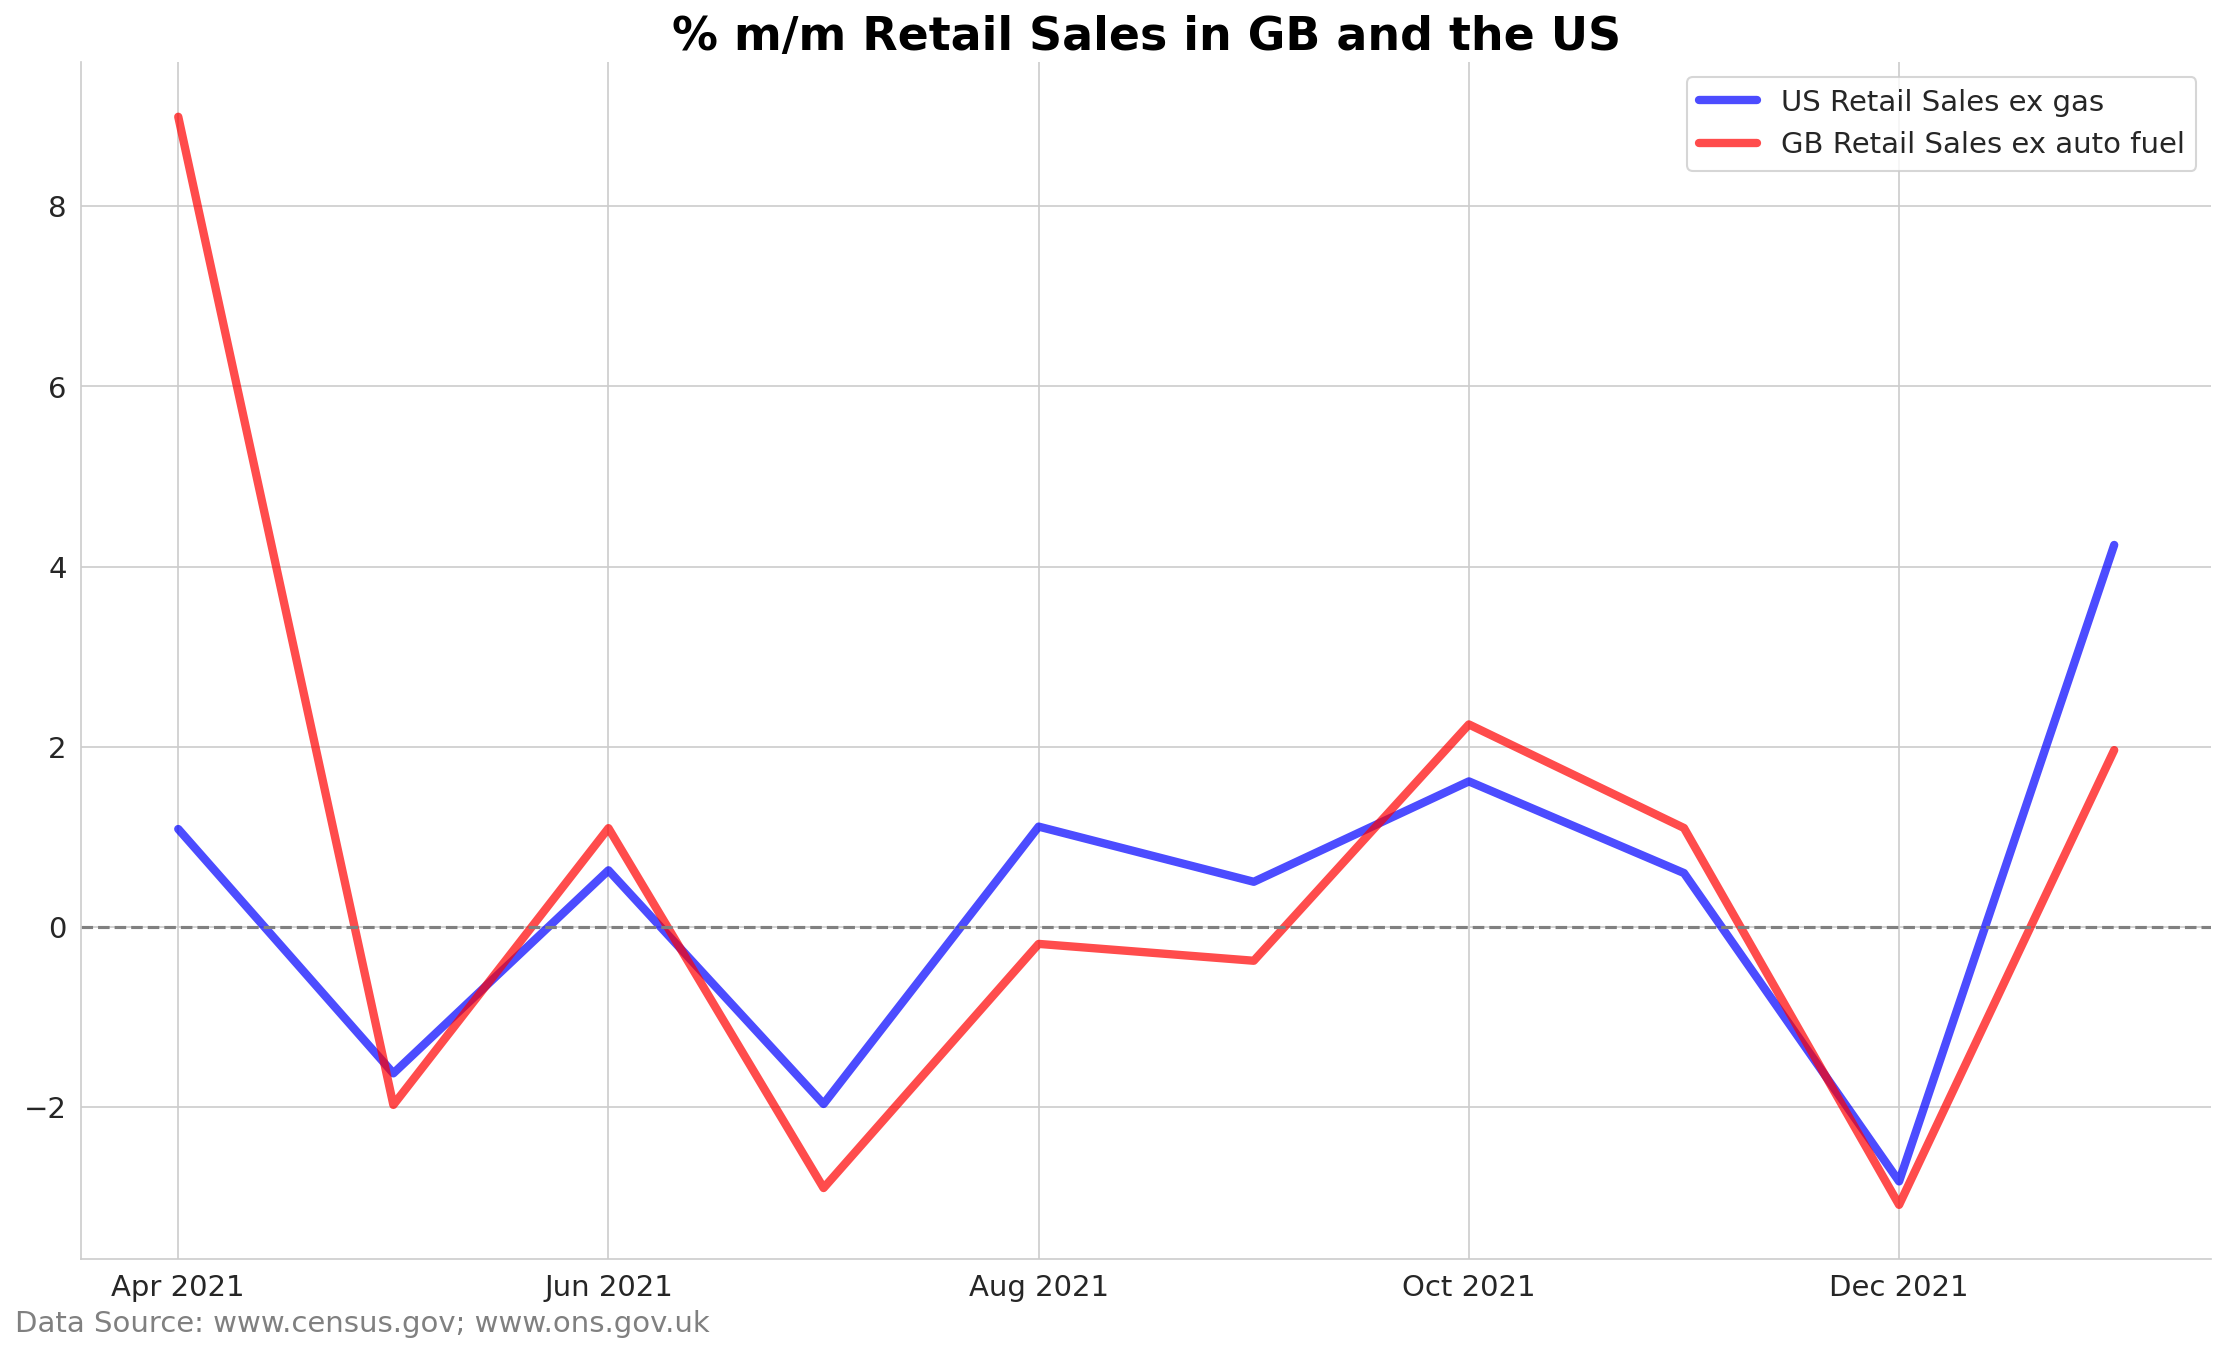

In [61]:
ax = df.iloc[-10:,:].plot(color=['b','r'],alpha=0.7,lw=4)
ax.legend(['US Retail Sales ex gas','GB Retail Sales ex auto fuel'])
ax.set_title('% m/m Retail Sales in GB and the US',fontsize=22,fontweight='bold',color='k')
ax.axhline(ls='--',color='gray')
plt.figtext(x=0.01,y=0.001,s='Data Source: www.census.gov; www.ons.gov.uk',color='gray')
sns.despine()
plt.tight_layout()

# ISM

In [535]:
# ISM | Composite PMI
# Latest release: https://www.census.gov/mtis/index.html
# Release date: Around 14th each month

quandl.get("ISM/MAN_PMI")

# ISM

In [535]:
# ISM | Composite PMI
# Latest release: https://www.census.gov/mtis/index.html
# Release date: Around 14th each month

quandl.get("ISM/MAN_PMI")

# BLS

In [74]:
core_cpi = pdr.DataReader('CPILFESL','fred')

In [81]:
(core_cpi.pct_change(12)*100).round(4)

,CPILFESL
DATE,
2017-04-01,NaN
2017-05-01,NaN
2017-06-01,NaN
2017-07-01,NaN
2017-08-01,NaN
...,...
2021-09-01,4.0368
2021-10-01,4.5940
2021-11-01,4.9526


In [614]:
codes = []

In [623]:
cpi_code_base = 'CUSR0000'

In [624]:
codes = []
for i in range(len(ic_lst)):
    cd = cpi_code_base+ic_lst[i]
    codes.append(cd)

In [869]:
#codes

In [879]:
df = pd.DataFrame()

In [ ]:
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(["series id","year","periodName","value"])
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['periodName']
        value = item['value']
        x.add_row([seriesId,year,period[:3],value])

In [881]:
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(["series id","year","periodName","value"])
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['periodName']
        value = item['value']
        x.add_row([seriesId,year,period[:3],value])
#    df.append(x)
    # output = open('cpi_data/'+seriesId + '.txt','w')
    # output.write (x.get_string())
    # output.close()

In [548]:
item_codes_df = pd.read_table('https://download.bls.gov/pub/time.series/cu/cu.item')

In [ ]:
lst_1 = ['All items','Commodities','Services','Food','Food at home','Food away from home',
         'Energy','Energy commodities','Energy services','All items less food and energy',
         'Commodities less food and energy commodities','Services less energy services',
         'Commodities less food, energy, and used cars and trucks']

In [582]:
lst_2 = pd.read_html('https://www.bls.gov/news.release/archives/cpi_01122022.htm')[0]['Expenditure category']

In [583]:
lst_2 = lst_2.dropna().iloc[:-1]

In [591]:
lst_2 = [i for i in lst_2['Expenditure category']]

In [592]:
lst_2 = [i.split('(')[0] for i in lst_2]

In [ ]:
lst_2 = ['All items','Food','Food at home','Cereals and bakery products','','','','','',
]

In [3]:
#codes

In [609]:
ic = item_codes_df[item_codes_df['item_name'].isin(lst_2)].iloc[:,:-3]

In [612]:
ic_lst = [i for i in ic['item_code']]

## TIC

In [9]:
tic_positions = pd.read_html('https://home.treasury.gov/news/press-releases/jy0559')[0].iloc[6:-20,5].dropna()
tic_positions = [i for i in tic_positions]

In [97]:
# Monthly Releases and Archives of Treasury International Capital (TIC) Data {Across-U.S. Border Financial Flows}
# TIC monthly reports on Cross-Border Portfolio Financial Flows
# ($ millions)
tic_monthly_all = pd.read_csv('https://treasury.gov/resource-center/data-chart-center/tic/Documents/npr_history.csv',
                  header=17,index_col='Unnamed: 0').dropna()
tic_monthly_all.index = pd.to_datetime(tic_monthly_all.index).strftime('%b \'%y')
tic_names = ['Gross Purch. of Domes. US L-T Secur.','Gross Foreign Sales of Domes. US L-T Secur.',
               'Domes L-T Secur. Purch., net','Private, net','Private Treas Bonds & Notes, net','Private Gov\'t Agency Bonds, net',
               'Private Corp Bonds, net','Private Equities, net','Official, net','Official Treas Bonds & Notes, net',
               'Official Gov\'t Agency Bonds, net','Official Corp Bonds, net	','Official Equities, net',
               'Gross Purch. of Foreign L-T Secur. from US',
              'Gross Foreign Sales of Foreign Secur. to US','Foreign L-T Securities Purch., net','Foreign Bonds Purch., net',
              'Foreign Equities Purch., net','Net L-T Secur. Transactions','Other Acquis. of L-T Secur., net ',
               'Net Foreign Acquis. of L-T Secur.',
               'Increase in Foreign Holdings of Dollar-denom S-T U.S. Sec. and Other Custody Liabs.',
               'U.S. Treasury Bills','Private, net','Official, net','Other Negot. Instr. & Select. Other Liabs.',
               'Private, net','Official, net','Change in Banks\' Own Net Dollar-denom. Liabs.',
               'Monthly Net TIC Flows','Private, net','Official, net']
tic_monthly_all.columns = tic_names

In [106]:
# Monthly Holdings of Securities (foreign holdings of U.S. securities, and U.S. holdings of foreign securities)

mhs = pd.read_csv('https://treasury.gov/resource-center/data-chart-center/tic/Documents/mfhhis01.csv',header=4,)

mhs_months = [i for i in mhs.iloc[0,1:-1]]
mhs = mhs.replace('------',np.nan)
mhs['Unnamed: 0'] = mhs['Unnamed: 0'].replace('Country','Year')
mhs = mhs.iloc[:,:-1].dropna()
mhs.index = mhs['Unnamed: 0']
mhs = mhs.iloc[:,1:]
mhs.columns = mhs_months
mhs.index.name = None

In [158]:
tc = pd.read_fwf('https://ticdata.treasury.gov/resource-center/data-chart-center/tic/Documents/snetus.txt',index_col='Unnamed: 0',header=5)

In [159]:
tc = tc.dropna()

In [575]:
mhs.head(20)

,Dec,Nov,Oct,Sep,Aug,Jul,Jun,May,Apr,Mar,Feb,Jan
Year,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020
Japan,1251.3,1260.8,1273.1,1276.2,1278.4,1293,1261.6,1260.4,1266.5,1272.6,1268.6,1211.8
"China, Mainland",1072.3,1063,1054,1061.7,1068,1073.4,1074.4,1083.7,1072.8,1081.6,1092.3,1078.6
United Kingdom,440.6,420.5,442.8,428.5,419.4,424.6,445.7,445.8,429.2,469.7,477.1,450.3
Ireland,318.1,314.2,316.3,315.7,335.2,330.7,330.2,324.2,301.3,271.6,282.8,271.7
Luxembourg,287.7,267.8,266.2,262.5,268.8,264.7,267.3,262.7,265.5,246.1,260.8,255.2
Brazil,258.3,262.2,262.9,265.1,265,265.7,264.1,264.4,259.5,264.4,285.9,283.3
Switzerland,255.5,253.3,255.5,255.4,253.4,250.4,247.3,243.1,241.3,244.6,243.7,238.1
Belgium,253.5,240.5,239.5,218.1,214.9,211.8,218.8,212.1,210.2,206.1,218,206.5
Taiwan,235.4,222.3,218.2,213.5,212,209.7,204.6,199.2,201.7,205,201.9,199.2


## Fed

### NYFED: Empire State Manufacturing Survey

In [415]:
# NYFED: Empire State Manufacturing Survey
# https://www.newyorkfed.org/survey/empire/empiresurvey_overview.html

ny_manufacturing = pd.read_csv('https://www.newyorkfed.org/medialibrary/media/survey/empire/data/esms_seasonallyadjusted_diffusion.csv?la=en',
                               index_col='surveyDate')
ny_manufacturing.index = pd.to_datetime(ny_manufacturing.index).strftime('%b \'%y')
ny_manufacturing_defs = read_pdf('https://www.newyorkfed.org/medialibrary/media/survey/empire/data/diffusion_idx.pdf',pages=1)
#definitions = pd.concat([definitions[0],definitions[1]],axis=0)
# Data definitions: https://www.newyorkfed.org/medialibrary/media/survey/empire/data/diffusion_idx.pdf

### Philadelphia Fed: Manufacturing Business Outlook Survey

In [27]:
# Manufacturing Business Outlook Survey Historical Data
# url: www.philadelphiafed.org/surveys-and-data/regional-economic-analysis/manufacturing-business-outlook-survey
#Seasonally Adjusted Diffusion Indexes

philly_fed_index = pd.read_csv('https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/mbos/historical-data/diffusion-indexes/bos_dif.csv?la=en&hash=433F3C508D5269FD08053D9CCB63FBD7',
                              index_col='DATE')
def_url = 'https://www.philadelphiafed.org/-/media/frbp/assets/surveys-and-data/mbos/historical-data/diffusion-indexes/readme_diffusionindexes.txt?la=en&hash=0ED4F076ADDD8D776CA223F6EE47C32F'
philly_definitions = pd.read_fwf(def_url).iloc[3:-1,0:1]
philly_cols = [str(i)[10:-2] for i in philly_definitions.values]

In [31]:
philly_fed_index.to_csv('US/philly_fed_index.csv')

Text(0.5, 1.0, 'Philly Fed Manufacturing Index: Future Delivery Time')

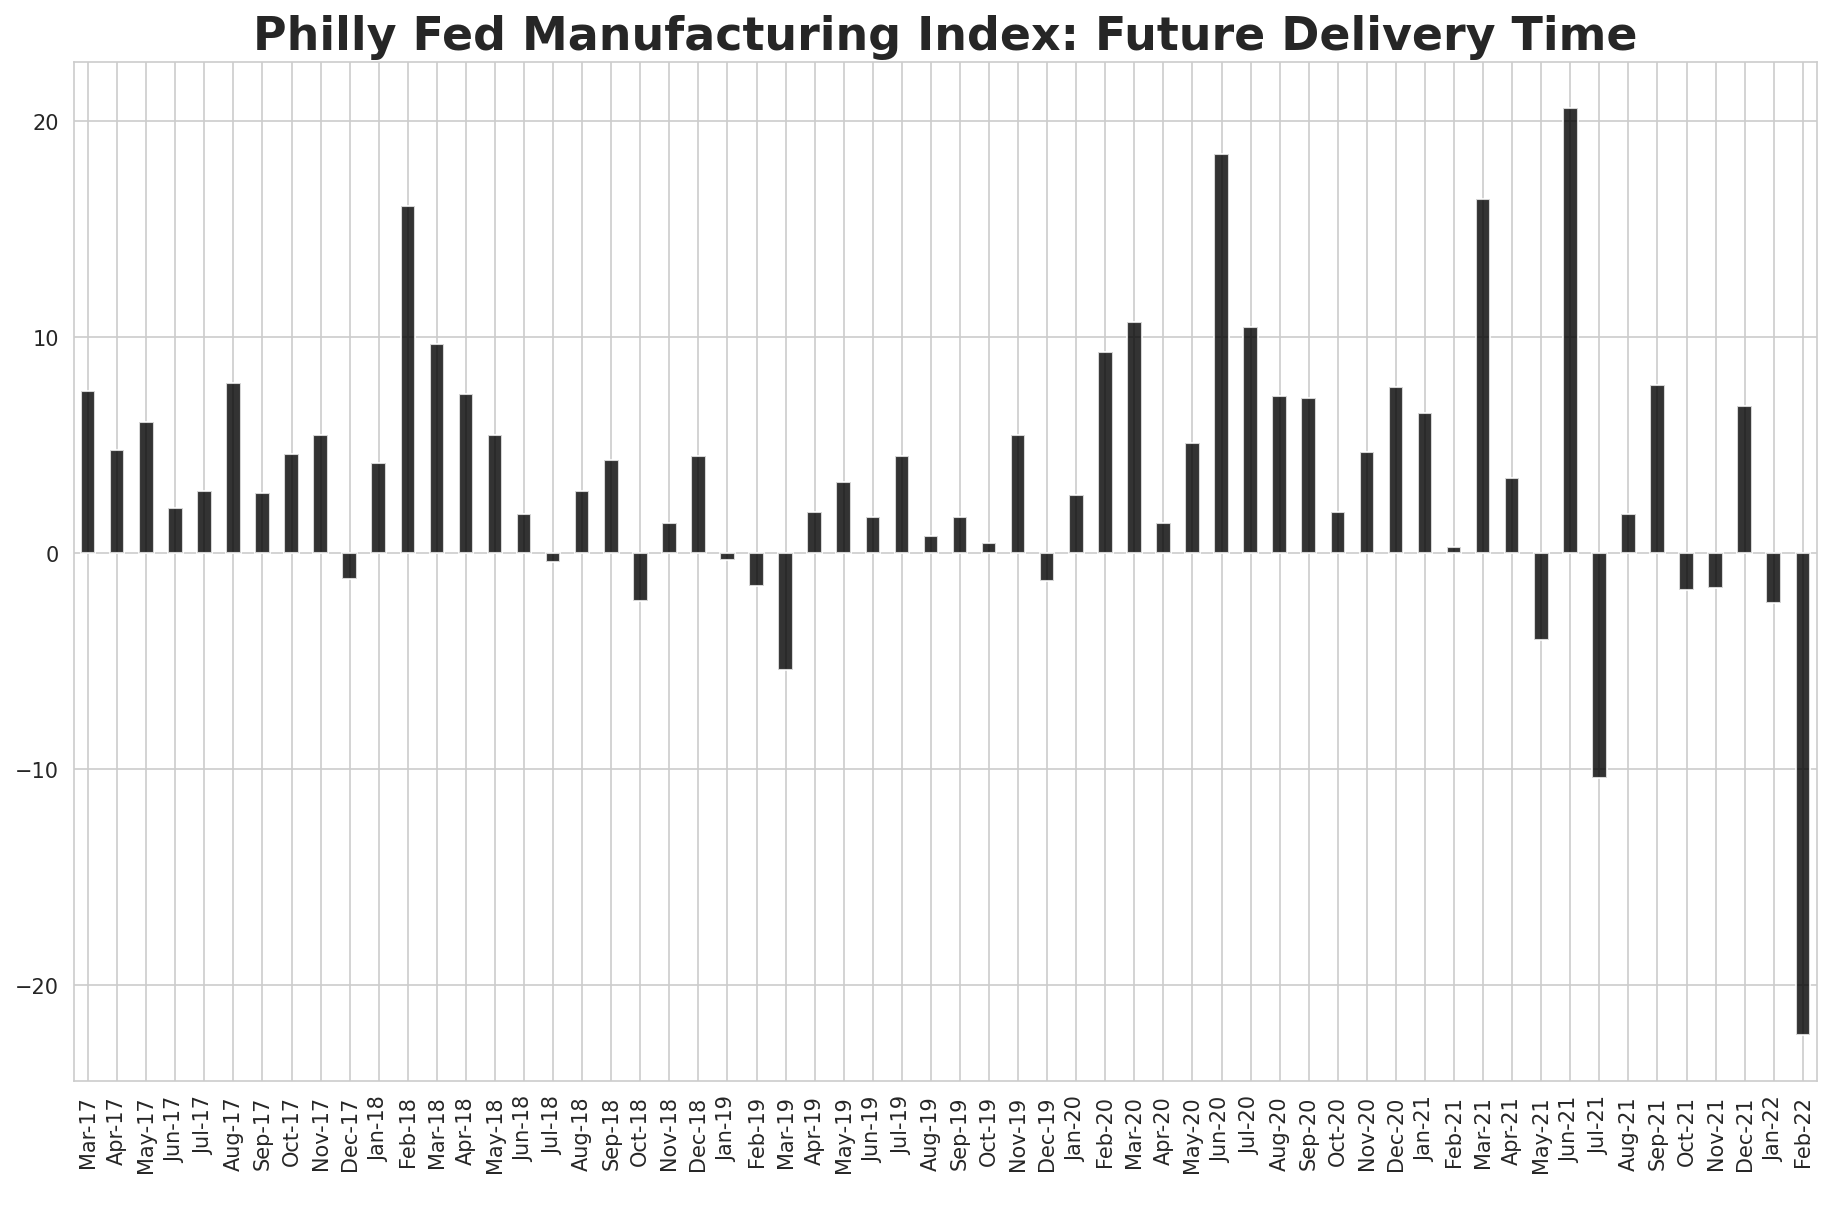

In [523]:
ax = philly_fed_index['Future Delivery Time'].iloc[-60:].plot(kind='bar',color='k',alpha=0.8)
ax.set_title('Philly Fed Manufacturing Index: Future Delivery Time',fontsize=22,fontweight='bold')

Text(0.5, 1.0, 'Philly Fed Manufacturing Index: Current New Orders')

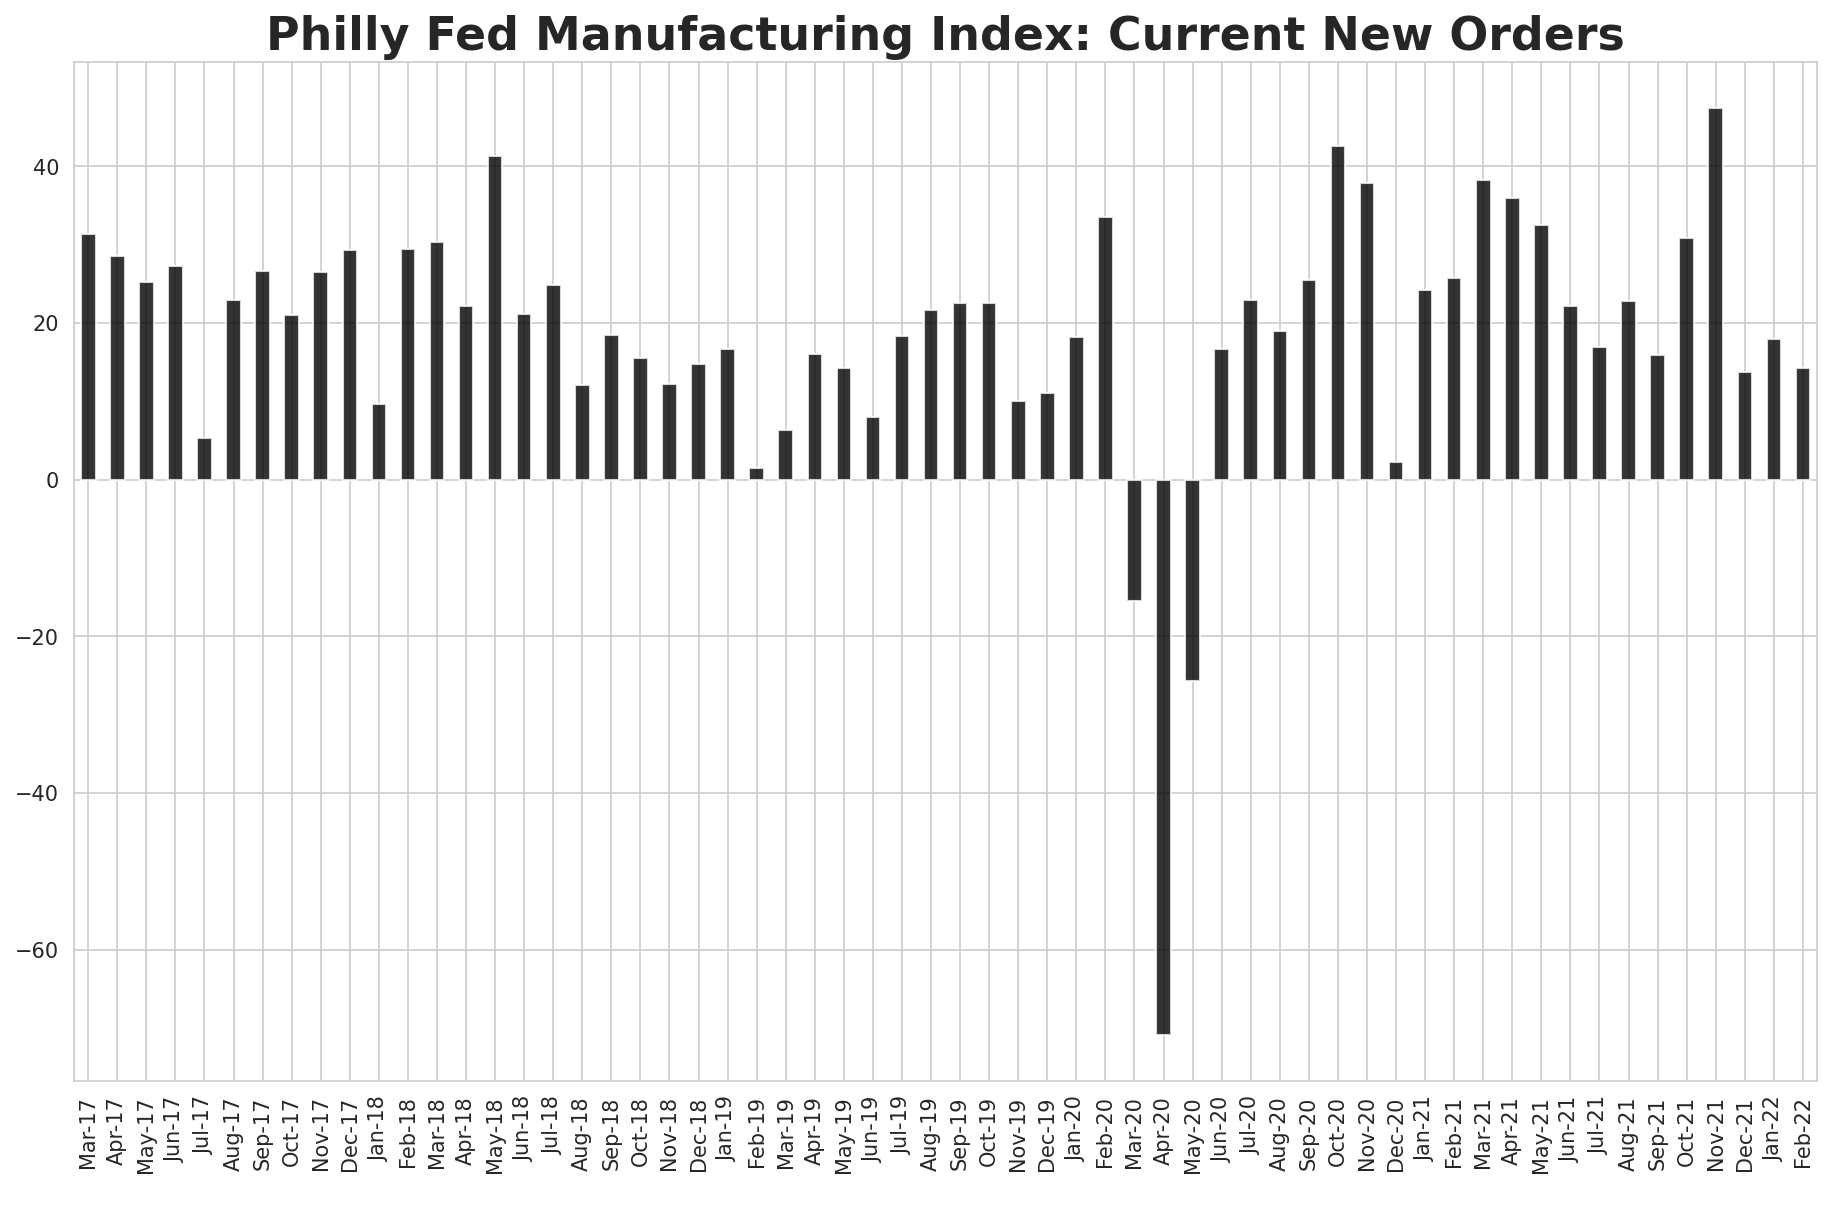

In [525]:
ax = philly_fed_index['Current New Orders'].iloc[-60:].plot(kind='bar',color='k',alpha=0.8)
ax.set_title('Philly Fed Manufacturing Index: Current New Orders',fontsize=22,fontweight='bold')

Text(0.5, 1.0, 'Philly Fed Manufacturing Index: Current Activity Index')

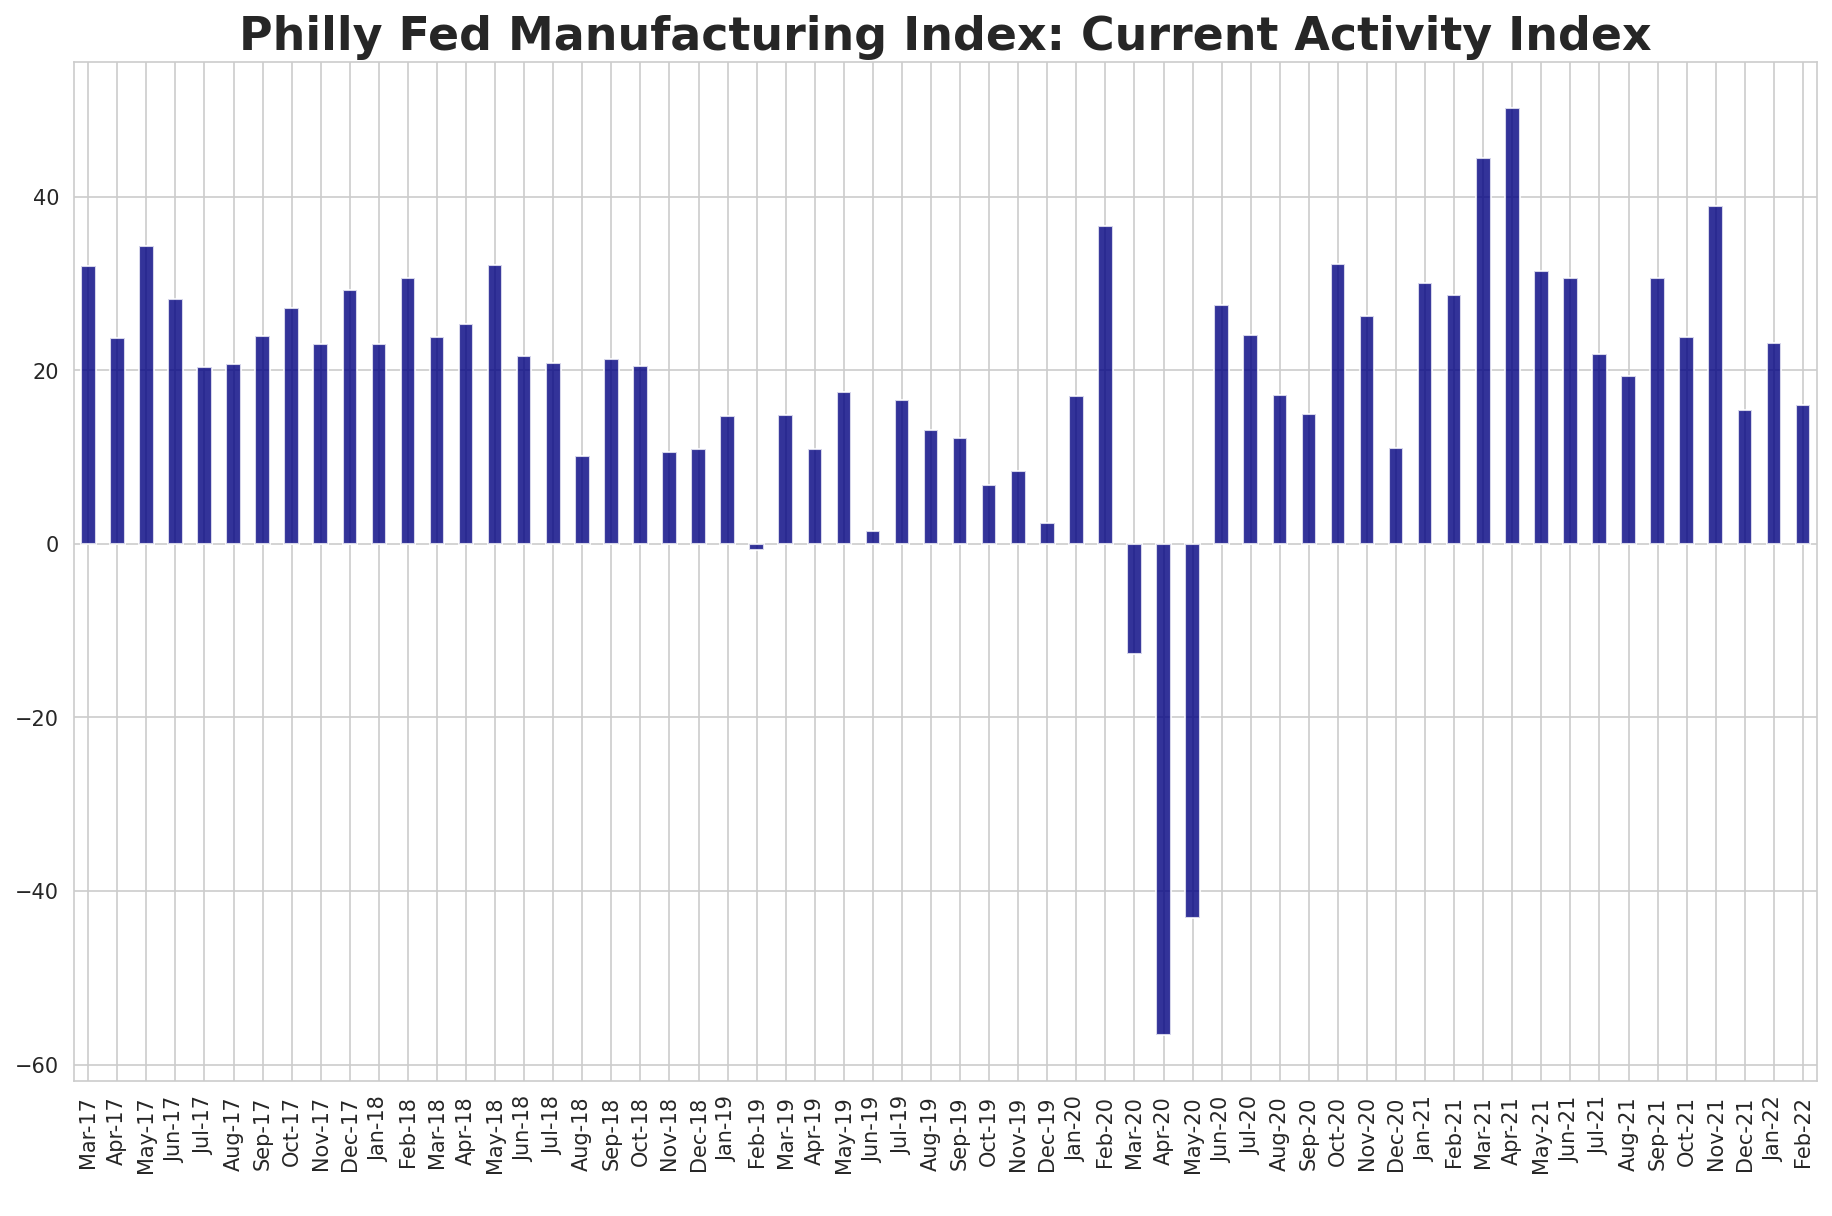

In [554]:
ax = philly_fed_index['Current Activity Index'].iloc[-60:].plot(kind='bar',color='navy',alpha=0.8)
ax.set_title('Philly Fed Manufacturing Index: Current Activity Index',fontsize=22,fontweight='bold')

<AxesSubplot:xlabel=' '>

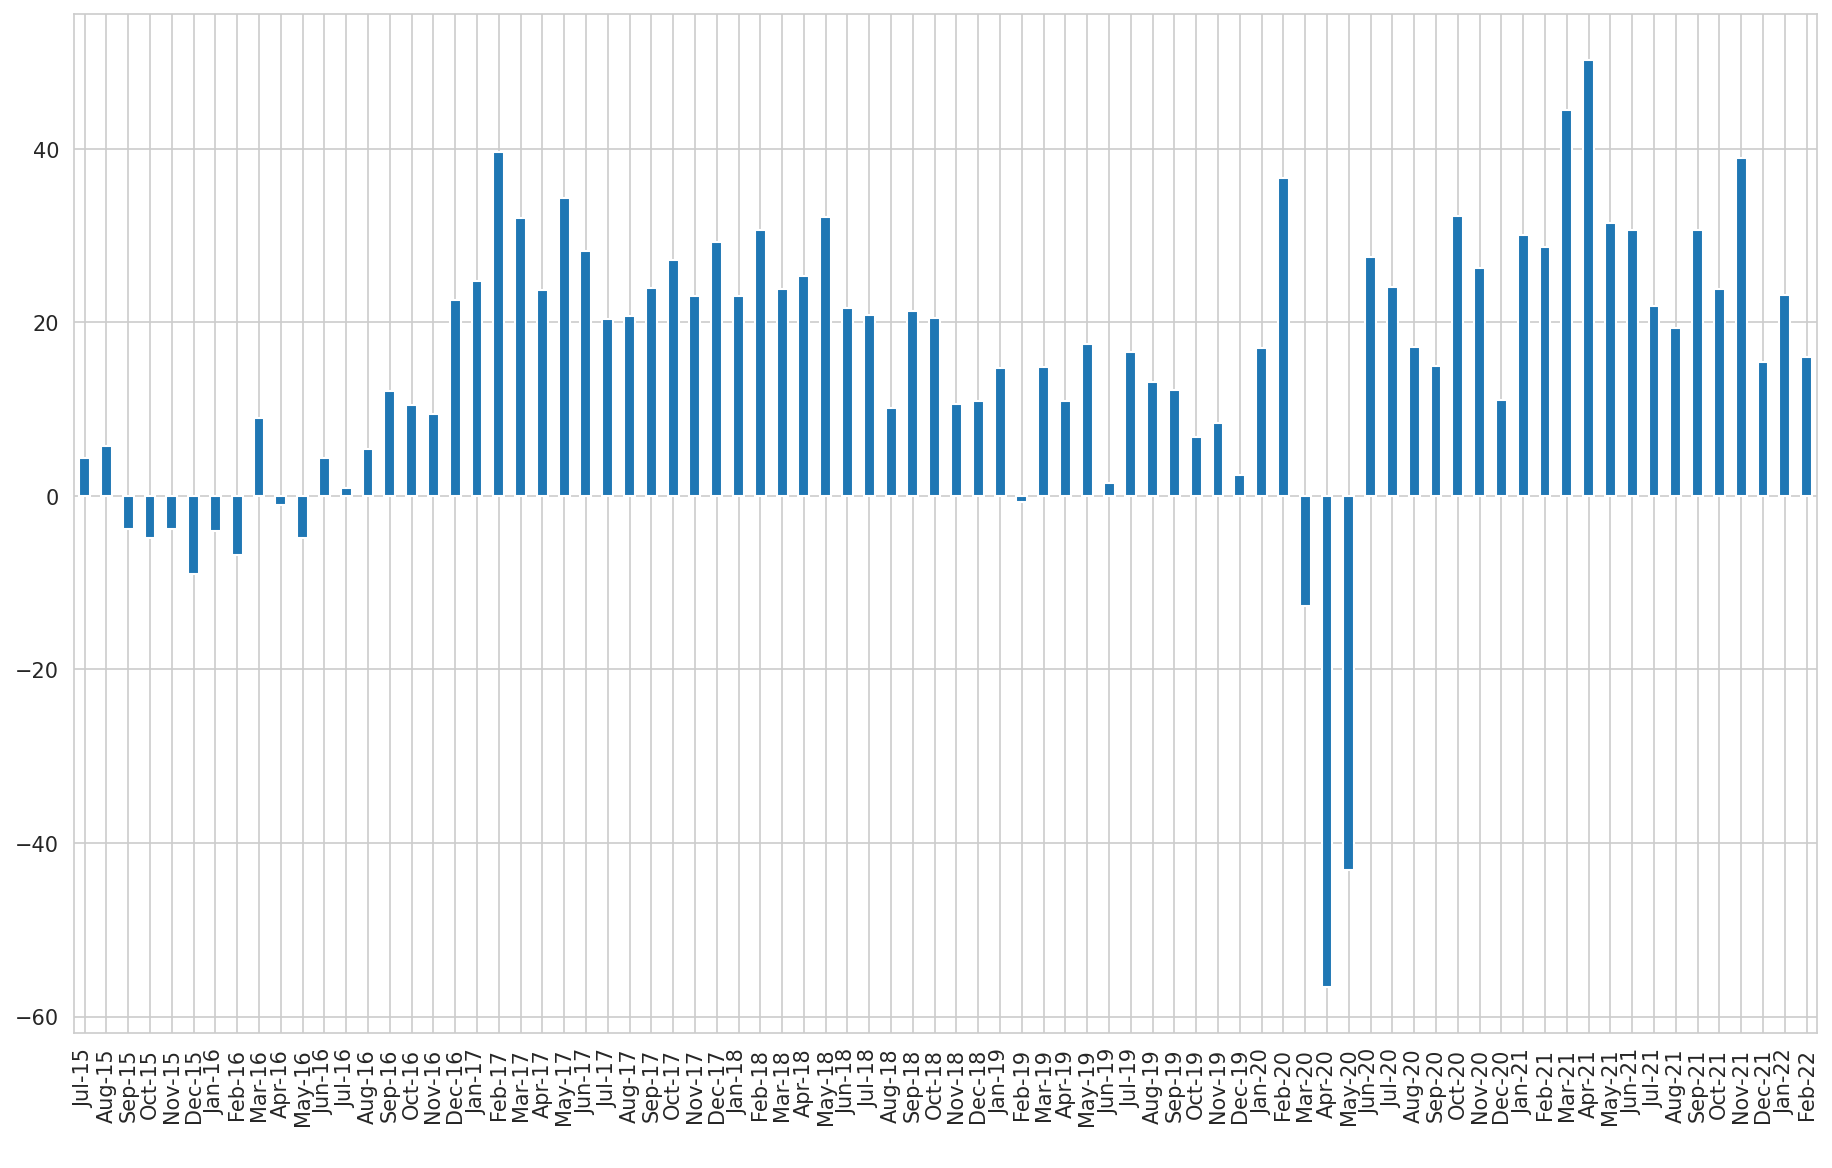

In [528]:
ax = philly_fed_index[''].iloc[-60:].plot(kind='bar',color='k',alpha=0.8)
ax.set_title('Philly Fed Manufacturing Index: Current New Orders',fontsize=22,fontweight='bold')

In [536]:
philly_fed_index.iloc[-1:].T

,Feb-22
,
Current Activity Index,16.0
Current New Orders,14.2
Current Shipments,13.4
Current Unfilled Orders,15.8
Current Delivery Time,23.0
Current Inventories,4.0
Current Prices Paid,69.3
Current Prices Received,49.8
Current Employment,32.3


In [559]:
mhs.head(20)

,Dec,Nov,Oct,Sep,Aug,Jul,Jun,May,Apr,Mar,Feb,Jan
Year,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020
Japan,1251.3,1260.8,1273.1,1276.2,1278.4,1293,1261.6,1260.4,1266.5,1272.6,1268.6,1211.8
"China, Mainland",1072.3,1063,1054,1061.7,1068,1073.4,1074.4,1083.7,1072.8,1081.6,1092.3,1078.6
United Kingdom,440.6,420.5,442.8,428.5,419.4,424.6,445.7,445.8,429.2,469.7,477.1,450.3
Ireland,318.1,314.2,316.3,315.7,335.2,330.7,330.2,324.2,301.3,271.6,282.8,271.7
Luxembourg,287.7,267.8,266.2,262.5,268.8,264.7,267.3,262.7,265.5,246.1,260.8,255.2
Brazil,258.3,262.2,262.9,265.1,265,265.7,264.1,264.4,259.5,264.4,285.9,283.3
Switzerland,255.5,253.3,255.5,255.4,253.4,250.4,247.3,243.1,241.3,244.6,243.7,238.1
Belgium,253.5,240.5,239.5,218.1,214.9,211.8,218.8,212.1,210.2,206.1,218,206.5
Taiwan,235.4,222.3,218.2,213.5,212,209.7,204.6,199.2,201.7,205,201.9,199.2


In [82]:
philly_fed_index

,GAC,NOC,SHC,UOC,DTC,IVC,PPC,PRC,NEC,AWC,...,NOF,SHF,UOF,DTF,IVF,PPF,PRF,NEF,AWF,CEF
DATE,,,,,,,,,,,,,,,,,,,,,
May-68,32.2,30.6,32.5,6.0,3.2,6.8,42.8,17.3,10.1,2.7,...,19.8,30.9,-1.5,-2.8,-14.9,74.3,41.3,18.7,2.9,22.7
Jun-68,18.4,18.2,11.9,-2.9,-4.4,10.6,35.0,15.8,12.2,4.1,...,30.6,43.0,12.8,-5.0,3.0,80.5,53.6,15.6,-4.1,25.3
Jul-68,33.3,15.7,23.8,1.2,-1.3,0.9,35.0,16.1,12.9,4.6,...,43.8,30.2,24.5,1.6,-0.4,70.5,46.0,22.7,-0.4,25.3
Aug-68,-3.9,-7.6,15.3,-6.6,-2.6,-24.6,43.3,23.0,13.3,6.3,...,36.6,29.9,8.3,0.2,0.9,64.7,40.2,21.5,5.0,18.5
Sep-68,9.5,20.7,21.6,-6.4,-5.4,1.4,28.5,12.7,1.9,4.0,...,20.8,36.6,-4.1,3.7,4.6,65.0,41.2,24.8,12.2,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Oct-21,23.8,30.8,30.0,12.7,32.2,18.8,70.3,51.1,30.7,27.8,...,26.2,30.5,-18.1,-1.7,23.6,64.1,58.8,37.5,27.2,32.4
Nov-21,39.0,47.4,32.1,27.4,35.7,13.5,80.0,62.9,27.2,30.6,...,28.0,39.8,-0.8,-1.6,14.1,63.9,59.4,49.3,9.7,31.1
Dec-21,15.4,13.7,15.3,11.4,31.4,13.2,66.1,50.4,33.9,30.4,...,24.2,32.0,-6.0,6.8,12.0,53.8,54.9,56.6,6.5,20.0


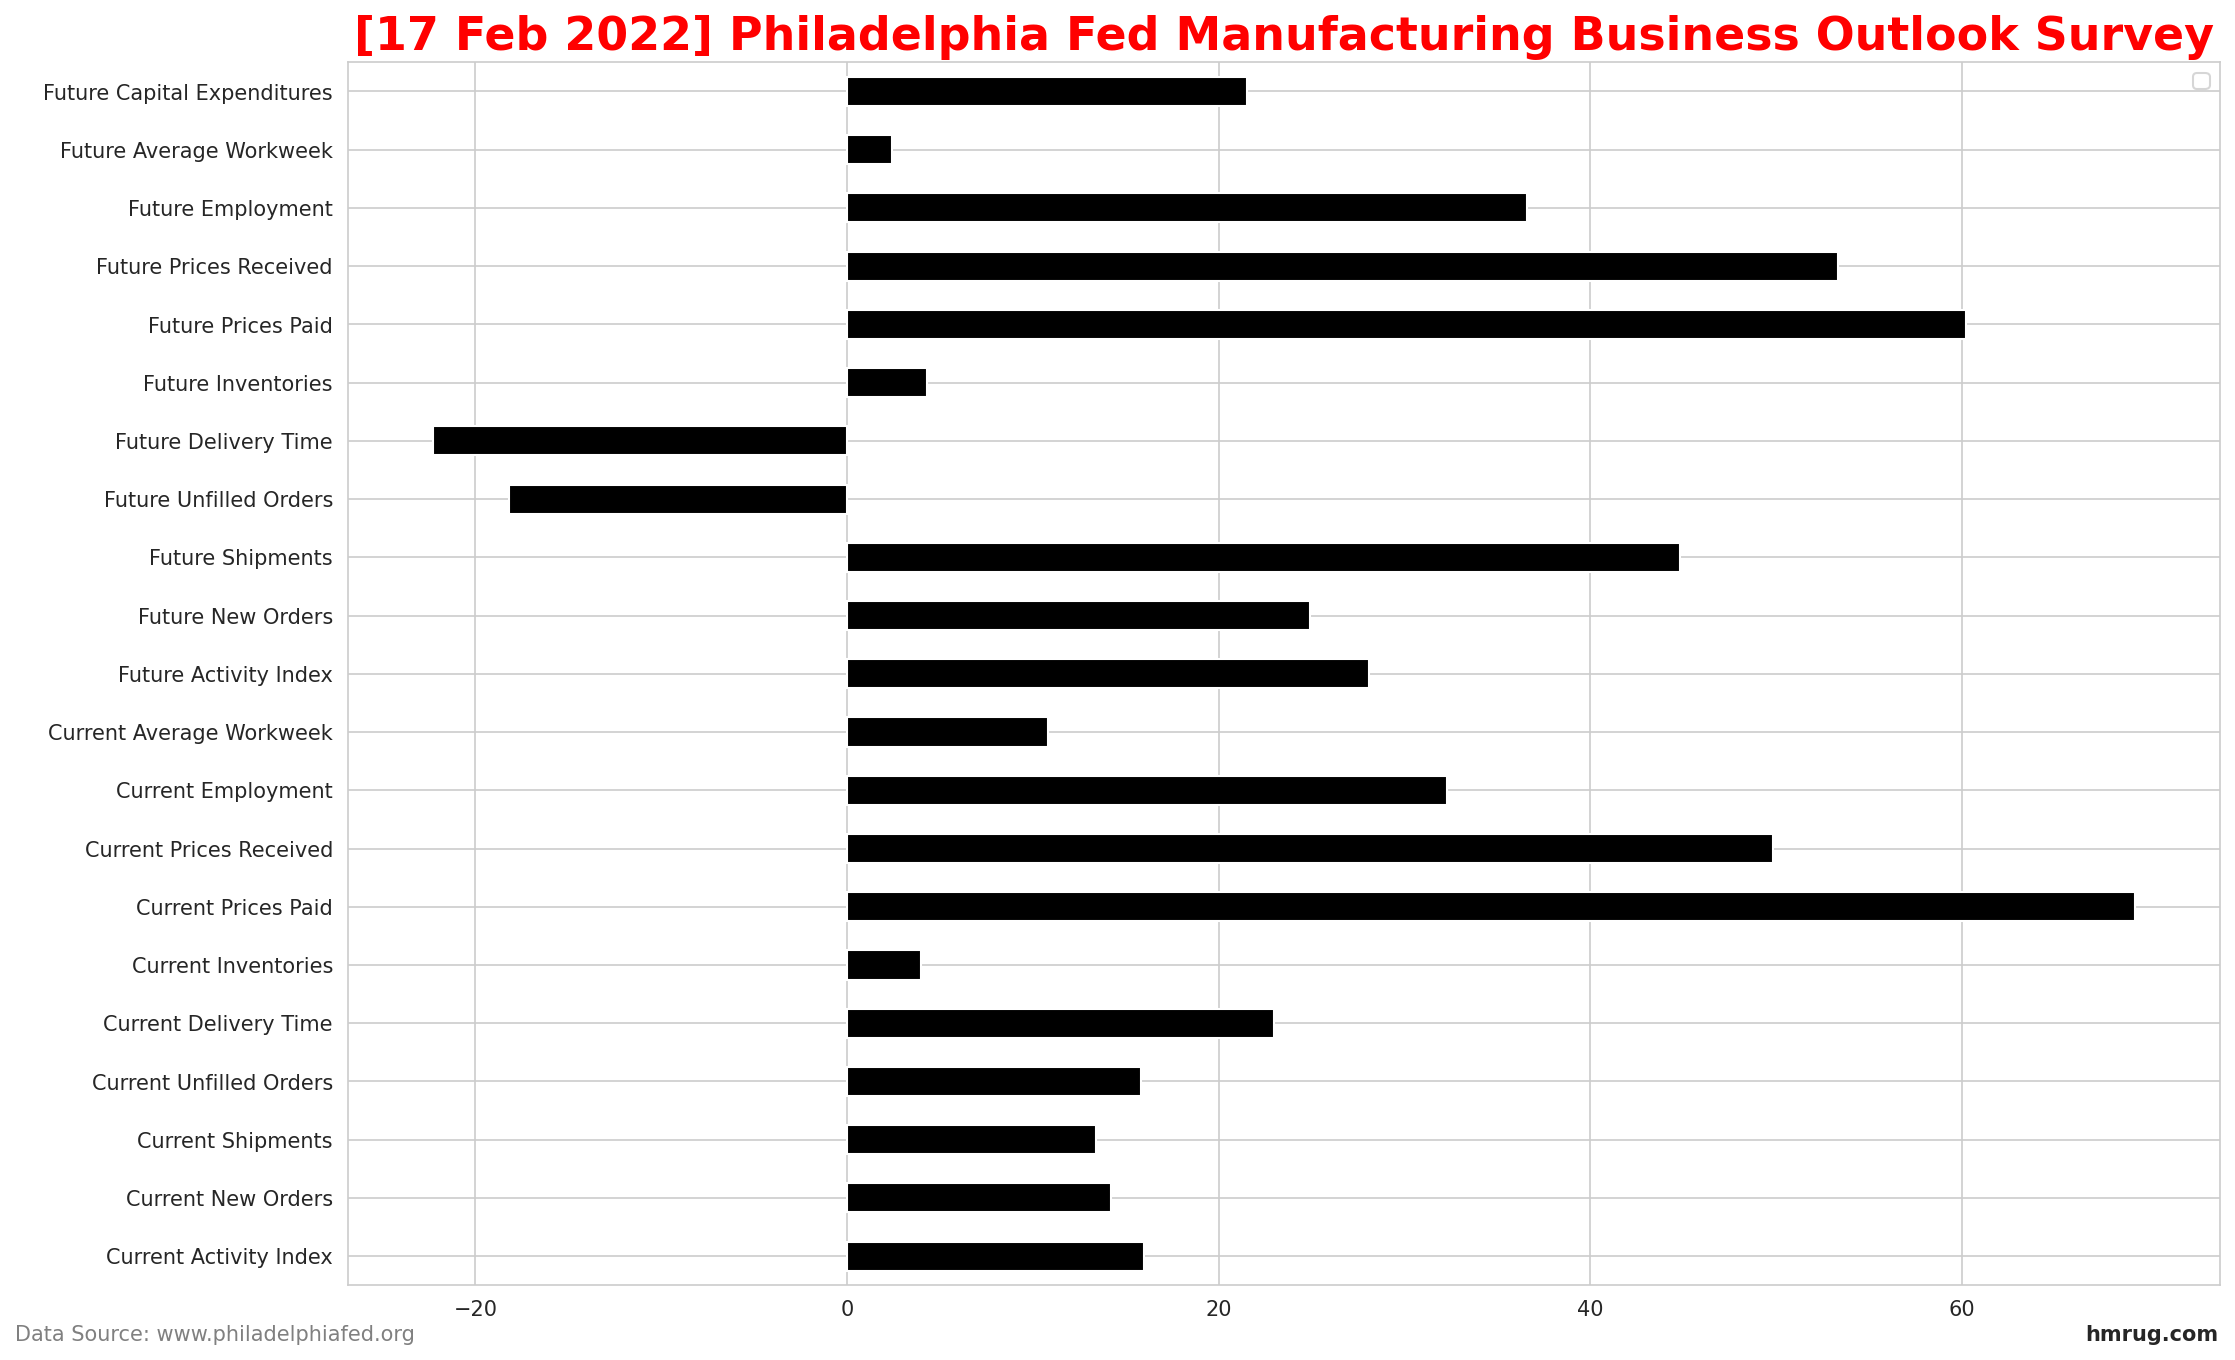

In [552]:
ax = philly_fed_index.iloc[-1:].T.plot(kind='barh',color='k')
ax.legend('')
ax.set_title('[17 Feb 2022] Philadelphia Fed Manufacturing Business Outlook Survey',fontsize=22,fontweight='bold',color='r')
plt.figtext(x=0.01,y=0.001,s='Data Source: www.philadelphiafed.org',color='gray')
plt.figtext(x=0.93,y=0.001,s='hmrug.com',fontweight='bold')
plt.tight_layout()

In [35]:
df = pdr.DataReader('DFII10','fred',start='2019-01-01')

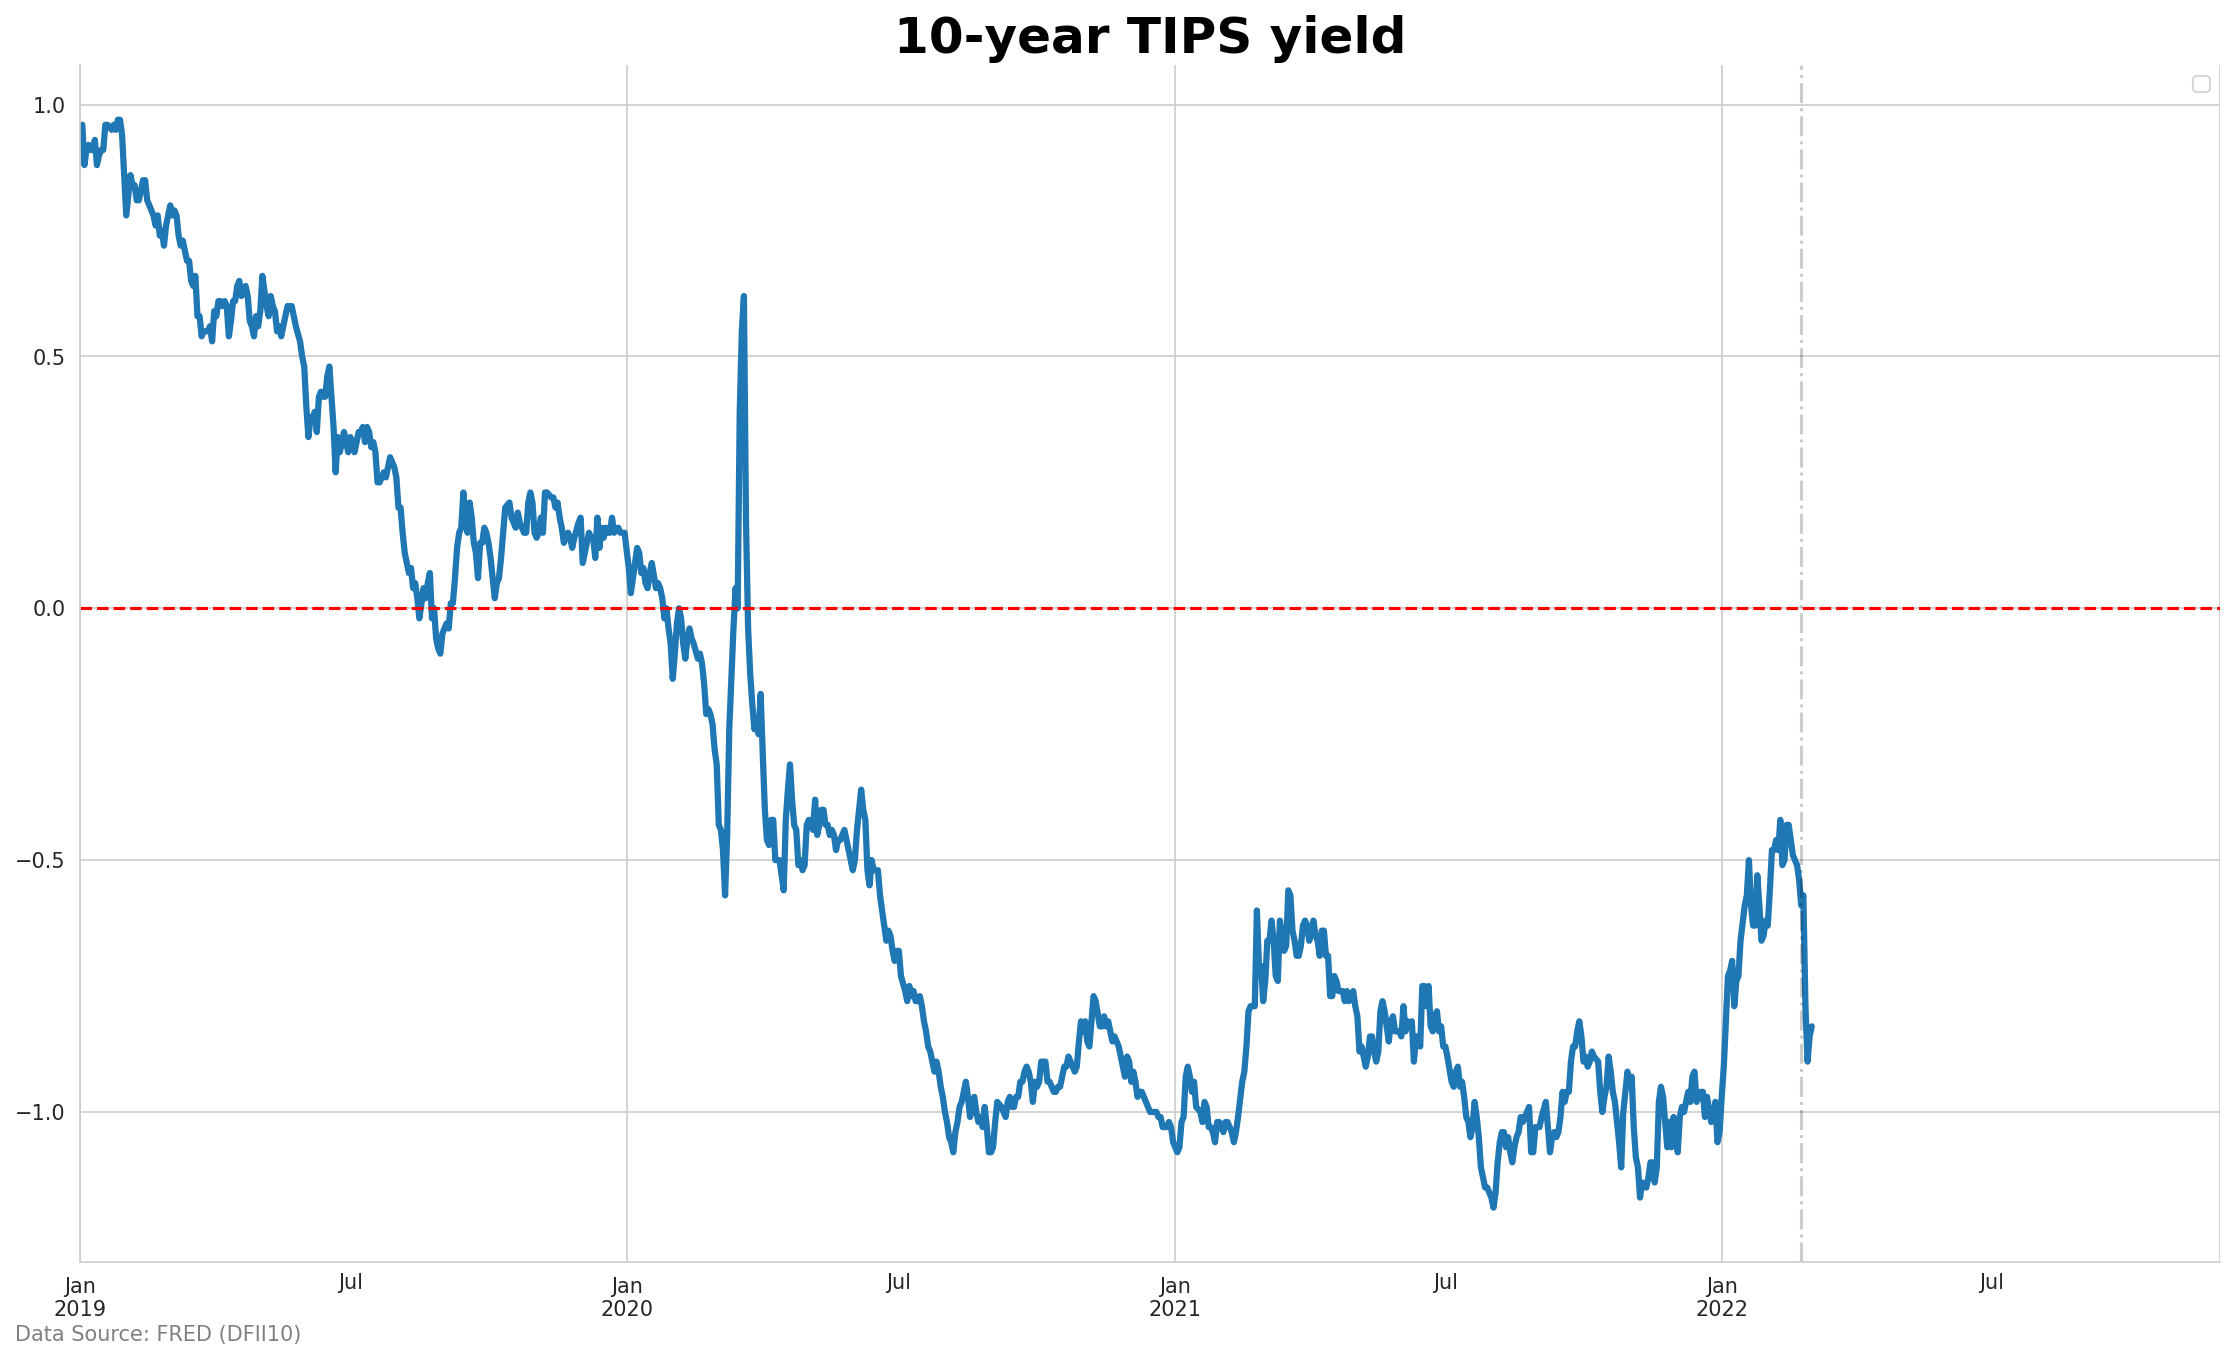

In [42]:
f, ax = plt.subplots(1,1)
df.interpolate().plot(lw=3,ax=ax)
ax.set_title('10-year TIPS yield',fontsize=24,fontweight='bold',c='k')
ax.set_xlim('2019-01-01','2022-12-01')
ax.axhline(color='r',ls='--')
ax.axvline('2022-02-24',color='k',ls='-.',alpha=0.2)

ax.legend('')
ax.set_xlabel('')
plt.figtext(x=0.01,y=0.001,s='Data Source: FRED (DFII10)',color='gray')
sns.despine()
plt.tight_layout()

# FED

## Industrial Production

In [423]:
url = 'https://www.federalreserve.gov/datadownload/Output.aspx?rel=G17&series=5d88c03b0036f0334d78f6bafefc5101&lastobs=&from=&to=&filetype=csv&label=include&layout=seriesrow&type=package'
ip = pd.read_csv(url,index_col='Descriptions:')

## Markit

## ISM: Manufacturing and Services PMI

In [22]:
# ISM | Manufacturing: PMI Composite Index ; 
# Latest release: https://www.census.gov/mtis/index.html
# Release date: Around 14th each month

ism_man = quandl.get('ISM/MAN_PMI')

ism_services = quandl.get('ISM/NONMAN_NMI')

ism = pd.concat([ism_man,ism_services],axis=1)
ism.columns = ['ISM Manufacturing PMI','ISM Services PMI']

In [26]:
ism.to_csv('US/ism.csv')

### Chicago PMI

## BLS

## Census

## Fed

## Philladelphia Fed

## NY Fed

## Richmond Fed

## University of Michigan

## US Treasury

## Yale

## CB

## NAR

## ADP